Carga de ruta de datos al modelo:

In [1]:
import os
import glob as gb
import cv2
import torch
from torchvision import datasets, models,transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold
from skimage.feature import graycomatrix, graycoprops

In [2]:
train_path = "/kaggle/input/skin-burns-dataset/skin burn dataset/train/"
test_path = "/kaggle/input/skin-burns-dataset/skin burn dataset/test/"
val_path = "/kaggle/input/skin-burns-dataset/skin burn dataset/valid/"

In [3]:
if torch.cuda.is_available():
    print(f"GPUs disponibles: {torch.cuda.device_count()}")
    for i in range(torch.cuda.device_count()):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    print("No se detectaron GPUs")

GPUs disponibles: 1
GPU 0: Tesla P100-PCIE-16GB


Cargamos los datos de entrenamiento cagetegorizados por carpetas

In [4]:
from PIL import Image

class_ = {'1st degree burn': 0, '2nd degree burn': 1 , '3nd degree burn': 2}

train_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.RandomVerticalFlip(),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.Resize(256),  # Cambiamos el tamaño al valor más pequeño, puede ser ancho o alto
    transforms.CenterCrop(224),  # Ahora recortamos el centro para hacer la imagen 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización basada en las estadísticas
])


# En las transformaciones de validación quitamos las alteraciones aleatorias
val_transform = transforms.Compose([
    transforms.Lambda(lambda image: image.convert('RGB') if isinstance(image, Image.Image) else image),
    transforms.Resize(256),  # Cambiamos el tamaño al valor más pequeño
    transforms.CenterCrop(224),  # Recortamos el centro para hacer la imagen 128x128
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalización
])

train_dataset = datasets.ImageFolder(root=train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(root=val_path, transform=val_transform)

# Crear los dataloaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=256, 
    shuffle=True,
    num_workers=4,  # Añadido para mejor rendimiento
    pin_memory=True  # Añadido para mejor rendimiento con GPU
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=256, 
    shuffle=False,
    num_workers=4,  # Añadido para mejor rendimiento
    pin_memory=True  # Añadido para mejor rendimiento con GPU
)

In [5]:
import torch

# Obtener un batch de imágenes del train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Imprimir el shape del primer batch de imágenes
print("Shape del batch de imágenes de entrenamiento:", images.shape)

# Imprimir el shape de una imagen individual del batch
print("Shape de una imagen individual:", images[0].shape)

Shape del batch de imágenes de entrenamiento: torch.Size([256, 3, 224, 224])
Shape de una imagen individual: torch.Size([3, 224, 224])


In [6]:
print(train_loader.dataset.classes)
print(val_loader.dataset.classes)

['1st degree burn', '2nd degree burn', '3nd degree burn']
['1st degree burn', '2nd degree burn', '3nd degree burn']


<PIL.Image.Image image mode=RGB size=128x128 at 0x7E9DBE0A3880>


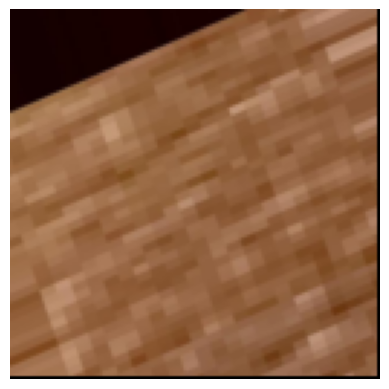

In [7]:
'''
Ahora se debe de conseguir que las imagenes sean todas cuadradas, ya que el resize cambiaba el aspecto de la imagen



utilizar el centro crop
'''

from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Ruta de la imagen
x = '/kaggle/input/skin-burns-dataset/skin burn dataset/train/1st degree burn/0_img0_jpg.rf.4a98fef2cf2e898395aa0ebf8eec50bc.jpg'

# Cargar la imagen
image = Image.open(x)

# Aplicar la transformación de redimensionamiento
transform = transforms.Resize(size= 127, max_size = 128)
transform2 = transforms.CenterCrop(128)
resized_image = transform2(transform(image))
print(resized_image)

# Mostrar la imagen transformada
plt.imshow(resized_image)
plt.axis('off')  # Opcional: quita los ejes
plt.show()

#solo usar para entrenar el modelo

In [8]:
import matplotlib.pyplot as plt

# Mostrar algunas imágenes de entrenamiento
def Show_images(loader):
    plt.figure(figsize=(10, 15))
    for n, (images, labels) in enumerate(loader):
        if n >= 36:
            break
        image = images[0]  # Selecciona la primera imagen del lote
        label = labels[0]  # Selecciona la primera etiqueta del lote
        plt.subplot(6, 6, n + 1)
        image = image.permute(1, 2, 0)  # Reordenar los ejes para mostrar la imagen
        plt.imshow((image * 0.5 + 0.5).numpy())  # Des-normalizar la imagen para mostrarla
        plt.axis('off')
        plt.title([key for key, value in class_.items() if value == label.item()][0], fontsize=10)
    plt.show()

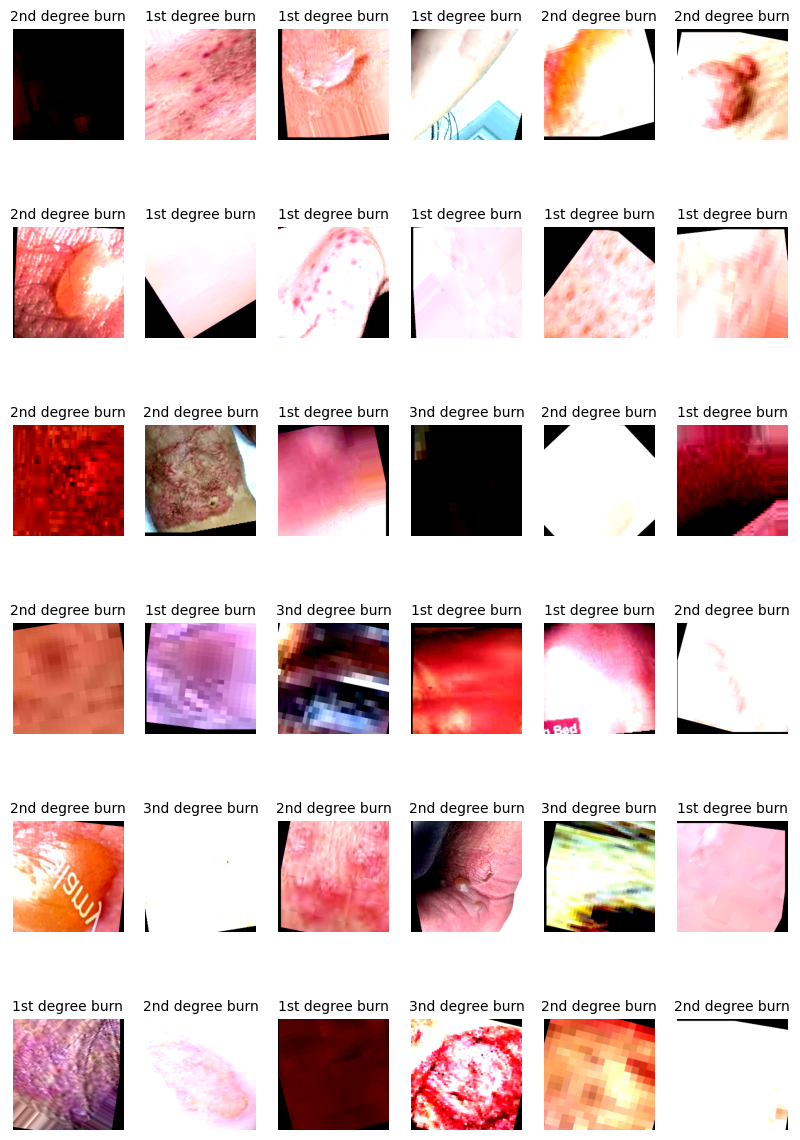

In [9]:
Show_images(train_loader)

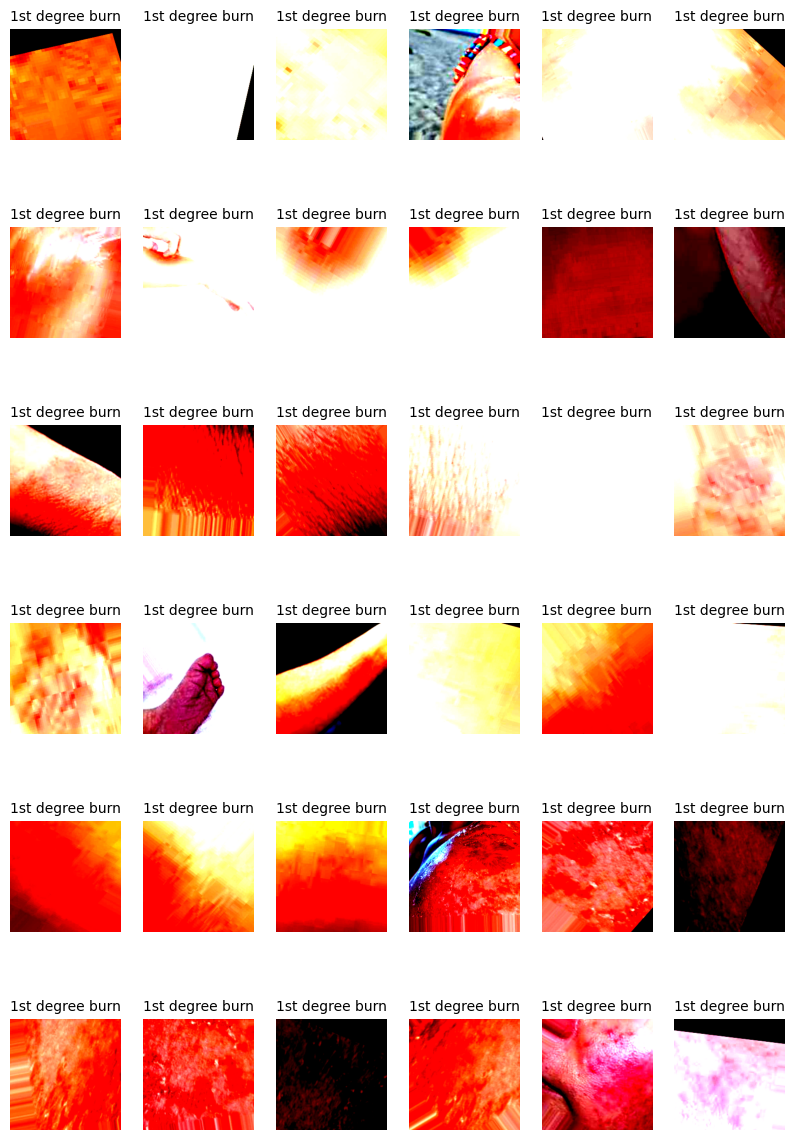

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Obtener un batch de imágenes del val_loader
data_iter = iter(val_loader)
images, labels = next(data_iter)

# Mostrar 36 imágenes del batch
plt.figure(figsize=(10, 15))
for n in range(36):
    if n >= len(images):  # no sobrepasar el número de imágenes en el batch
        break
    image = images[0]  # Selecciona la primera imagen del lote
    label = labels[0]  # Selecciona la primera etiqueta del lote
    plt.subplot(6, 6, n + 1)
    plt.imshow(images[n].permute(1, 2, 0))  # Cambia las dimensiones de [C, H, W] a [H, W, C] para visualizar
    plt.axis('off')
    plt.title([key for key, value in class_.items() if value == label.item()][0], fontsize=10)

plt.show()

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models

# Inicializar el modelo VGG16 con los pesos preentrenados de ImageNet
model = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1)

# Reemplazar la última capa fully connected para 3 clases
num_ftrs = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_ftrs, 3)

# Enviar el modelo al dispositivo (GPU o CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Poner el modelo en modo de evaluación
model.eval()

# Imprimir la confirmación de carga de modelo
print("Modelo VGG16 cargado y ajustado correctamente con pesos preentrenados de ImageNet")

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 234MB/s]  


Modelo VGG16 cargado y ajustado correctamente con pesos preentrenados de ImageNet


In [11]:
# Ruta para guardar el modelo
save_path = '/kaggle/working/vgg16_burn_classification.pth'

# Guardar los pesos del modelo
torch.save(model.state_dict(), save_path)

print(f"Modelo guardado correctamente en: {save_path}")

Modelo guardado correctamente en: /kaggle/working/vgg16_burn_classification.pth


In [12]:
# Inicializar un nuevo modelo VGG16 con la misma arquitectura
vgg16 = models.vgg16(weights=None)

# Reemplazar la última capa fully connected para 3 clases
num_ftrs = model.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_ftrs, 3)

# Enviar el modelo al dispositivo
vgg16 = vgg16.to(device)

# Cargar los pesos guardados desde Kaggle
load_path = '/kaggle/working/vgg16_burn_classification.pth'
vgg16.load_state_dict(torch.load(load_path))

print(f"Modelo cargado correctamente desde: {load_path}")

/tmp/ipykernel_30/1298473850.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vgg16.load_state_dict(torch.load(load_path))


Modelo cargado correctamente desde: /kaggle/working/vgg16_burn_classification.pth


In [16]:
from torchvision import models, datasets, transforms
from torch.utils.data import DataLoader, SubsetRandomSampler
from sklearn.metrics import f1_score
from sklearn.model_selection import KFold
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from PIL import Image

# Almacenar las métricas por época
train_losses = []
train_accuracies = []
train_f1_scores = []
val_losses = []
val_accuracies = []
val_f1_scores = []
best_val_loss = float('inf')
best_val_accuracy = 0.0
results = {}

# Suponiendo que tienes el train_loader ya configurado y el modelo ajustado
k_folds = 5
num_epochs = 20
num_classes = 3
num_ftrs = 512 * 7 * 7 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Cargar el modelo VGG16 pre-entrenado
vgg16 = models.vgg16(pretrained=True)


# Preparar K-Fold Cross Validation
kfold = KFold(n_splits=k_folds, shuffle=True)

# Ajustar los hiperparámetros
learning_rate = 0.00001  # Learning rate más bajo
weight_decay = 1e-4 # Regularización con Weight Decay

vgg16.classifier = nn.Sequential(
   nn.Linear(num_ftrs, 1024),
   nn.ReLU(),
   nn.Dropout(0.7),
   nn.Linear(1024, 512),
   nn.ReLU(),
   nn.Dropout(0.7),
   nn.Linear(512, num_classes)
)

vgg16 = vgg16.to(device)

# Descongelar más capas
for param in vgg16.features[-4:].parameters():  # Últimas 4 capas convolucionales
    param.requires_grad = True

train_labels = [label for _, label in train_dataset]

# Configurar la matriz de confusión
unique_classes = np.unique(train_labels)
conf_matrix = np.zeros((len(unique_classes), len(unique_classes)))

# Definir optimizador y función de pérdida
optimizer = optim.Adam(vgg16.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Puedes ajustar el learning rate según tu caso
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights = torch.FloatTensor(class_weights).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Para clasificación multiclase
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10, verbose=True)

for fold, (train_idx, val_idx) in enumerate(kfold.split(train_dataset)):
    print(f'Fold {fold+1}/{k_folds}')

    best_accuracy = 0.0
    
    # Definir los DataLoader para los splits de entrenamiento y validación
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    # Definir los DataLoader para los splits de entrenamiento y validación
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_idx)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_idx)
    
    train_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=128, 
        sampler=train_subsampler,
        num_workers=4  # Ajusta según tu CPU
    )
    
    val_loader = torch.utils.data.DataLoader(
        train_dataset, 
        batch_size=128, 
        sampler=val_subsampler,
        num_workers=4  # Ajusta según tu CPU
    )
            
    # Ciclo de entrenamiento para cada fold
    for epoch in range(num_epochs):
        vgg16.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_preds_train = []
        all_labels_train = []
        
        for inputs, labels in train_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            outputs = vgg16(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # Calcular la pérdida acumulada y la precisión
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct_train += torch.sum(preds == labels).item()
            total_train += labels.size(0)

            all_preds_train.extend(preds.cpu().numpy())
            all_labels_train.extend(labels.cpu().numpy())
    
        train_loss = running_loss / len(train_loader)
        train_acc = np.mean(np.array(all_preds_train) == np.array(all_labels_train))
        train_f1 = f1_score(all_labels_train, all_preds_train, average='macro')

        # Almacenar métricas de entrenamiento
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        train_f1_scores.append(train_f1)
        
        # Validación y cálculo de matriz de confusión
        vgg16.eval()
        running_loss_val = 0.0
        correct_val = 0
        total_val = 0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = vgg16(inputs)
                loss = criterion(outputs, labels)
                running_loss_val += loss.item()

                _, preds = torch.max(outputs, 1)
                correct_val += torch.sum(preds == labels).item()
                total_val += labels.size(0)
                
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss = running_loss_val / len(val_loader)
        val_acc = correct_val / total_val
        val_f1 = f1_score(all_labels, all_preds, average='macro')

        # Almacenar métricas de validación
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        val_f1_scores.append(val_f1)

        scheduler.step(val_loss)
        
        # Imprimir las métricas de entrenamiento y validación para la época actual
        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, '
              f'Training Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}, '
              f'Training F1 Score: {train_f1:.4f}, Validation F1 Score: {val_f1:.4f}')
        
        # Guardar el mejor modelo basado en la precisión de validación
        if val_acc > best_accuracy:
            best_accuracy = val_acc
            torch.save(vgg16.state_dict(), 'vgg16_entrenado.pth')
            print('Modelo mejorado, guardado.')

    # Actualizar la matriz de confusión
    conf_matrix += confusion_matrix(all_labels, all_preds)

    # Guardar los resultados por fold
    acc = np.sum(np.array(all_preds) == np.array(all_labels)) / len(all_labels)
    print(f'Precisión en el fold {fold + 1}: {acc:.4f}')
    results[fold] = acc

# Resultados finales
print(f'Resultados de los {k_folds} folds: {results}')
print(f'Promedio de precisión: {np.mean(list(results.values())):.4f}')

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Fold 1/5


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/20], Training Loss: 0.8176, Validation Loss: 0.5431, Training Accuracy: 0.5948, Validation Accuracy: 0.7671, Training F1 Score: 0.5869, Validation F1 Score: 0.7589
Modelo mejorado, guardado.
Epoch [2/20], Training Loss: 0.5226, Validation Loss: 0.4487, Training Accuracy: 0.7785, Validation Accuracy: 0.8123, Training F1 Score: 0.7703, Validation F1 Score: 0.8019
Modelo mejorado, guardado.
Epoch [3/20], Training Loss: 0.4379, Validation Loss: 0.3884, Training Accuracy: 0.8206, Validation Accuracy: 0.8386, Training F1 Score: 0.8113, Validation F1 Score: 0.8278
Modelo mejorado, guardado.
Epoch [4/20], Training Loss: 0.3942, Validation Loss: 0.3788, Training Accuracy: 0.8398, Validation Accuracy: 0.8292, Training F1 Score: 0.8317, Validation F1 Score: 0.8185
Epoch [5/20], Training Loss: 0.3636, Validation Loss: 0.3470, Training Accuracy: 0.8528, Validation Accuracy: 0.8522, Training F1 Score: 0.8440, Validation F1 Score: 0.8424
Modelo mejorado, guardado.
Epoch [6/20], Training Loss

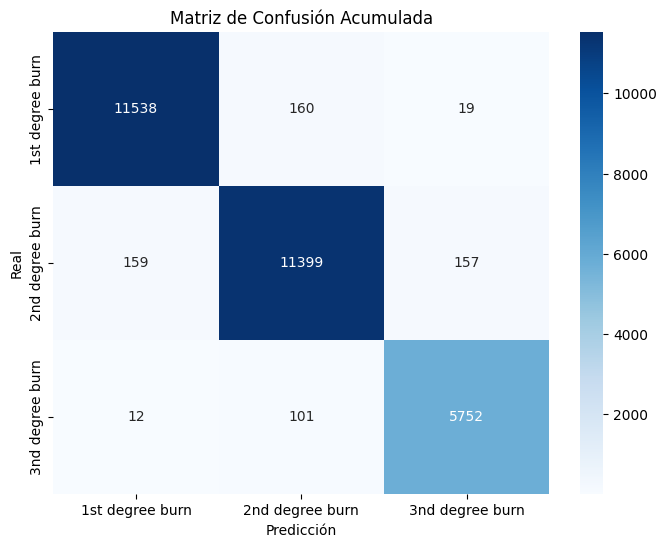

In [17]:
# Graficar la matriz de confusión acumulada
plt.figure(figsize=(8, 6))
class_names = ['1st degree burn', '2nd degree burn', '3nd degree burn']  # Ajustar según las clases que tengas
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.title('Matriz de Confusión Acumulada')
plt.show()

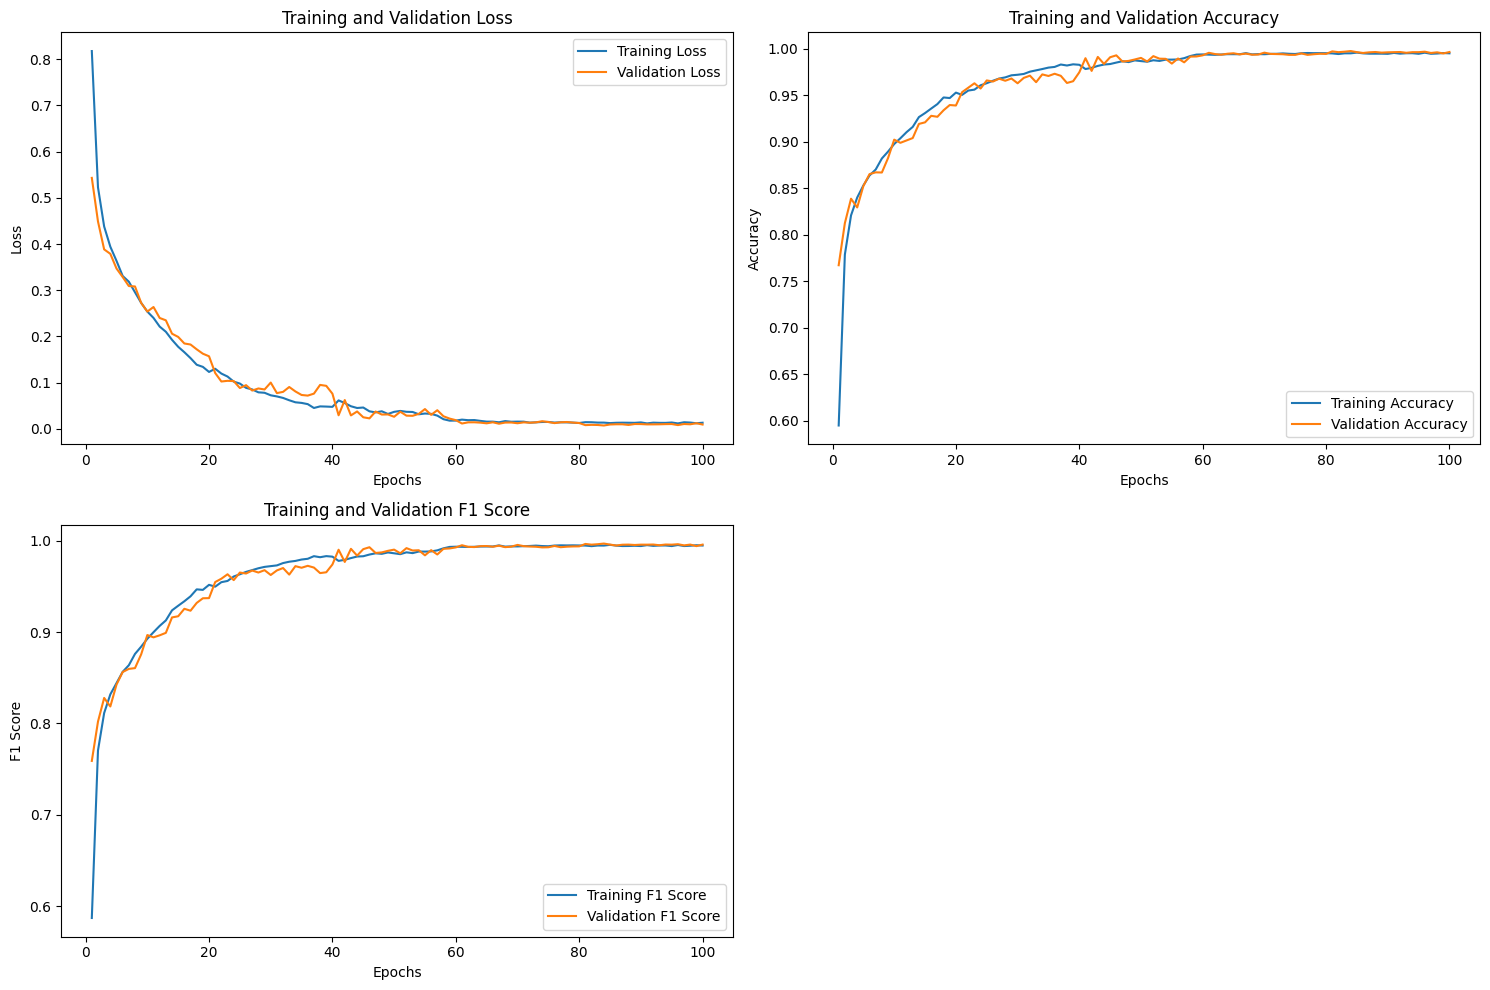

In [18]:
# Graficar las métricas
epochs = range(1, num_epochs * k_folds + 1)

plt.figure(figsize=(15, 10))

# Gráfico de la pérdida
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

# Gráfico de la precisión
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, val_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Gráfico del F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_f1_scores, label='Training F1 Score')
plt.plot(epochs, val_f1_scores, label='Validation F1 Score')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Training and Validation F1 Score')
plt.legend()

plt.tight_layout()
plt.show()